In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


23/08/25 12:46:37 WARN Utils: Your hostname, Ungs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.12.45.216 instead (on interface en0)
23/08/25 12:46:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/25 12:46:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/25 12:46:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/08/25 12:46:39 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/08/25 12:46:39 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols, glm
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [3]:
sdf = spark.read.parquet('../data/curated/hourly_demand')
sdf.show()

+----------+----+--------+------------+---------+------------------+----------+--------------+------------------+-----------+--------------+------------+
|      date|hour|day_week|pulocationid|num_trips|is_weekend_holiday|wind_speed|ceiling_height|distance_dimension|temperature|dew_point_temp|atm_pressure|
+----------+----+--------+------------+---------+------------------+----------+--------------+------------------+-----------+--------------+------------+
|2023-05-01|  14|       2|          12|        3|             false|      46.0|        1981.0|           16093.0|      144.0|          33.0|      9934.0|
|2023-05-01|  14|       2|          13|       32|             false|      46.0|        1981.0|           16093.0|      144.0|          33.0|      9934.0|
|2023-05-01|  14|       2|          14|        1|             false|      46.0|        1981.0|           16093.0|      144.0|          33.0|      9934.0|
|2023-05-01|  14|       2|          21|        1|             false|      46

In [4]:
# 'date' is not predictor so drop it
sdf = sdf.drop('date')
sdf.show()

+----+--------+------------+---------+------------------+----------+--------------+------------------+-----------+--------------+------------+
|hour|day_week|pulocationid|num_trips|is_weekend_holiday|wind_speed|ceiling_height|distance_dimension|temperature|dew_point_temp|atm_pressure|
+----+--------+------------+---------+------------------+----------+--------------+------------------+-----------+--------------+------------+
|  14|       2|          12|        3|             false|      46.0|        1981.0|           16093.0|      144.0|          33.0|      9934.0|
|  14|       2|          13|       32|             false|      46.0|        1981.0|           16093.0|      144.0|          33.0|      9934.0|
|  14|       2|          14|        1|             false|      46.0|        1981.0|           16093.0|      144.0|          33.0|      9934.0|
|  14|       2|          21|        1|             false|      46.0|        1981.0|           16093.0|      144.0|          33.0|      9934.0|

In [5]:
# change to pandas df 
df = sdf.toPandas()

In [6]:
# numerical attributes that need to be standardize
x_cols = ['wind_speed', 'temperature', 'distance_dimension','ceiling_height',
          'dew_point_temp', 'atm_pressure']

# standardize (by calculating the zscore) so our data has mean 0 and var 1
from scipy.stats import zscore

# combine the standardized column with the original columns that are not standardized
df = pd.concat([df[x_cols].astype(float).apply(zscore),
    df.drop(x_cols, axis = 1)], axis = 1)

In [7]:
sdf.printSchema()

root
 |-- hour: integer (nullable = true)
 |-- day_week: integer (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- num_trips: long (nullable = true)
 |-- is_weekend_holiday: boolean (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- ceiling_height: double (nullable = true)
 |-- distance_dimension: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- dew_point_temp: double (nullable = true)
 |-- atm_pressure: double (nullable = true)



# OLS

In [8]:
# fit a linear regression and to perform significance test on every weather attribute
fit = ols(
    formula="num_trips ~ wind_speed + ceiling_height + distance_dimension + temperature +\
        dew_point_temp + atm_pressure ",
    data=df
).fit()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              num_trips   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     639.1
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:46:54   Log-Likelihood:            -2.5565e+06
No. Observations:              445827   AIC:                         5.113e+06
Df Residuals:                  445820   BIC:                         5.113e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             46.7866      0

In [10]:
degrees_of_freedom = fit.df_resid

In [11]:
# obtain the 99th percentile from t distribution
import scipy.stats as stats
import numpy as np
quantile_99= stats.t.ppf(0.99, df=degrees_of_freedom)
print(f"The 99th quantile of the t-distribution with {degrees_of_freedom} degrees of freedom is: {quantile_99}")

The 99th quantile of the t-distribution with 445820.0 degrees of freedom is: 2.326356238598452


In [12]:
# eliminate the dew point which is highly correlated with temperature 
# remove distance which has the lowest t-statistics
fit_2 = ols(
    formula="num_trips ~ wind_speed + ceiling_height + temperature +\
         atm_pressure ",
    data=df
).fit()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [13]:
print(fit_2.summary())

                            OLS Regression Results                            
Dep. Variable:              num_trips   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     687.8
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:46:55   Log-Likelihood:            -2.5570e+06
No. Observations:              445827   AIC:                         5.114e+06
Df Residuals:                  445822   BIC:                         5.114e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         46.7866      0.112    416.

In [14]:
fit.aic, fit_2.aic, f"abs diff: {abs(fit_2.aic - fit.aic)}"

(5113029.693968573, 5114101.371888814, 'abs diff: 1071.6779202409089')

The first fit of linear regression is better as it has lower AIC so we retained all features.

In [15]:
sample_df = pd.read_parquet('../data/curated/sample_data.parquet')
sample_df = sample_df.drop('date', axis = 1)
sample_df.head()

,hour,day_week,num_trips,is_weekend_holiday,wind_speed,ceiling_height,distance_dimension,temperature,dew_point_temp,atm_pressure,...,pulocationid_254,pulocationid_255,pulocationid_256,pulocationid_257,pulocationid_258,pulocationid_259,pulocationid_260,pulocationid_261,pulocationid_262,pulocationid_263
0,0,3,2,False,2.6,792.0,14484.0,16.1,12.2,1016.4,...,0,0,0,0,0,0,0,0,0,0
1,0,3,11,False,2.6,792.0,14484.0,16.1,12.2,1016.4,...,0,0,0,0,0,0,0,0,0,0
2,0,3,3,False,2.6,792.0,14484.0,16.1,12.2,1016.4,...,0,0,0,0,0,0,0,0,0,0
3,0,3,47,False,2.6,792.0,14484.0,16.1,12.2,1016.4,...,0,0,0,0,0,0,0,0,0,0
4,0,3,15,False,2.6,792.0,14484.0,16.1,12.2,1016.4,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# used for prediction
may_df = pd.read_parquet('../data/curated/may_sample_data.parquet')
may_df = may_df.drop('date', axis = 1)
may_df.head()

,hour,day_week,num_trips,is_weekend_holiday,wind_speed,ceiling_height,distance_dimension,temperature,dew_point_temp,atm_pressure,...,pulocationid_254,pulocationid_255,pulocationid_256,pulocationid_257,pulocationid_258,pulocationid_259,pulocationid_260,pulocationid_261,pulocationid_262,pulocationid_263
0,0,2,2,False,5.1,183.0,3219.0,16.1,15.6,988.3,...,0,0,0,0,0,0,0,0,0,0
1,0,2,40,False,5.1,183.0,3219.0,16.1,15.6,988.3,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,False,5.1,183.0,3219.0,16.1,15.6,988.3,...,0,0,0,0,0,0,0,0,0,0
3,0,2,16,False,5.1,183.0,3219.0,16.1,15.6,988.3,...,0,0,0,0,0,0,0,0,0,0
4,0,2,1,False,5.1,183.0,3219.0,16.1,15.6,988.3,...,0,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# drop the redundant features
X_train = sample_df.drop(['num_trips','day_week'], axis = 1)
y_train = sample_df['num_trips']

X_test = may_df.drop(['num_trips', 'day_week'], axis = 1)
y_test = may_df['num_trips']

In [18]:
print(len(X_train))

76076


In [19]:
X_train.head()

,hour,is_weekend_holiday,wind_speed,ceiling_height,distance_dimension,temperature,dew_point_temp,atm_pressure,pulocationid_1,pulocationid_2,...,pulocationid_254,pulocationid_255,pulocationid_256,pulocationid_257,pulocationid_258,pulocationid_259,pulocationid_260,pulocationid_261,pulocationid_262,pulocationid_263
0,0,False,2.6,792.0,14484.0,16.1,12.2,1016.4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,False,2.6,792.0,14484.0,16.1,12.2,1016.4,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,False,2.6,792.0,14484.0,16.1,12.2,1016.4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,False,2.6,792.0,14484.0,16.1,12.2,1016.4,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,False,2.6,792.0,14484.0,16.1,12.2,1016.4,0,0,...,0,0,0,0,0,0,0,0,0,0


# Linear Regression

In [20]:
# fit the linear regression model
lr = LinearRegression().fit(X_train,y_train)


In [21]:
print(lr.score(X_train,y_train))

0.6091595710574369


In [22]:
lr_pred = lr.predict(X_test)


print(lr.score(X_test,y_test))

0.6137844923900861


In [23]:
print('R2: ',r2_score(y_test, lr_pred))

R2:  0.6137844923900861


In [24]:
print('RMSE: ', np.sqrt(mean_squared_error(y_test, lr_pred)))

RMSE:  47.94155248972239


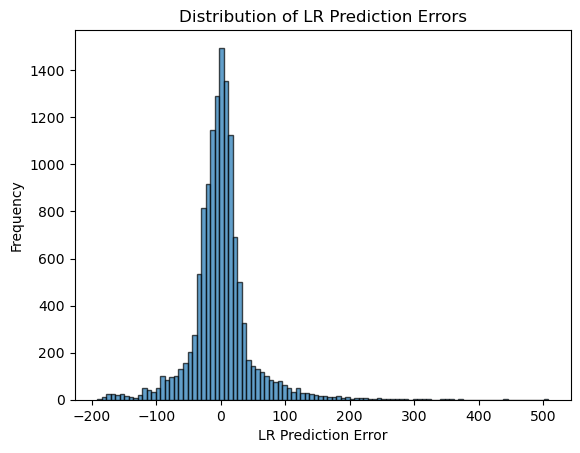

In [40]:
# Calculate prediction errors
lr_prediction_errors = np.array(y_test) - np.array(lr_pred)

# Plot the distribution of LR prediction errors
plt.hist(lr_prediction_errors, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('LR Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of LR Prediction Errors')
# plt.show()
plt.savefig('../plots/dist_lr_errors.png', dpi=300, bbox_inches='tight')

# Random Forest Regression

In [26]:
# Hyperparameter tuning using grid search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
params = { 
          'n_estimators':  [200, 300],
          'max_depth': [5,6,8],                  
          'min_samples_leaf': [2, 4],          
          'min_samples_split' : [2, 5],     
         }


rf = RandomForestRegressor()
rs = GridSearchCV(estimator=rf, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
rs.fit(X_train, y_train)
print(rs.best_estimator_)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [27]:
# fit the random forest regression model using tuned hyperparameter
rf = rs.best_estimator_
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [28]:
print('-'*30)
r2 = r2_score(y_test, rf_pred)
print('R2: ', r2)
err = np.sqrt(mean_squared_error(y_test, rf_pred))
print('Root Mean Squared Error: ', err)


------------------------------
R2:  0.46918826686493464
Root Mean Squared Error:  56.20403515022458


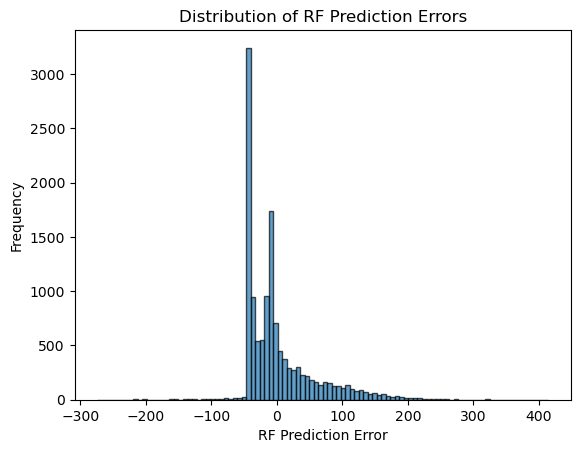

In [41]:
# Calculate prediction errors
rf_prediction_errors = np.array(y_test) - np.array(rf_pred)

# Plot the distribution of RF prediction error
plt.hist(rf_prediction_errors, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('RF Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of RF Prediction Errors')
# plt.show()
plt.savefig('../plots/dist_rf_errors.png', dpi=300, bbox_inches='tight')

# Prediction of data on 22th May 2023

In [29]:
# Now predict the data on 22th May 2023
sample_test = pd.read_parquet("../data/curated/may_sample_data.parquet")
sample_test['date'] = pd.to_datetime(sample_test['date'])
sample_test = sample_test.loc[sample_test['date'] == '2023-05-22']
X_sample = sample_test.drop(['date', 'num_trips', 'day_week'], axis = 1)
y_sample = sample_test['num_trips']
sample_test.head()

,date,hour,day_week,num_trips,is_weekend_holiday,wind_speed,ceiling_height,distance_dimension,temperature,dew_point_temp,...,pulocationid_254,pulocationid_255,pulocationid_256,pulocationid_257,pulocationid_258,pulocationid_259,pulocationid_260,pulocationid_261,pulocationid_262,pulocationid_263
9212,2023-05-22,0,2,1,False,2.1,22000.0,16093.0,19.4,9.4,...,0,0,0,0,0,0,0,0,0,0
9213,2023-05-22,0,2,1,False,2.1,22000.0,16093.0,19.4,9.4,...,0,0,0,0,0,0,0,0,0,0
9214,2023-05-22,0,2,57,False,2.1,22000.0,16093.0,19.4,9.4,...,0,0,0,0,0,0,0,0,0,0
9215,2023-05-22,0,2,2,False,2.1,22000.0,16093.0,19.4,9.4,...,0,0,0,0,0,0,0,0,0,0
9216,2023-05-22,0,2,11,False,2.1,22000.0,16093.0,19.4,9.4,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# linear regression 
sample_lr_pred = lr.predict(X_sample)

print(lr.score(X_sample,y_sample))

0.6043792929240224


In [31]:
# Random forest regression
sample_rf_pred = rf.predict(X_sample)

print(rf.score(X_sample,y_sample))

0.5828447863487782


In [32]:
# combine the prediction and actual value
X_sample['lr_pred'] = sample_lr_pred
X_sample['rf_pred'] = sample_rf_pred
X_sample['ground_truth'] = y_sample
X_sample.head()


,hour,is_weekend_holiday,wind_speed,ceiling_height,distance_dimension,temperature,dew_point_temp,atm_pressure,pulocationid_1,pulocationid_2,...,pulocationid_257,pulocationid_258,pulocationid_259,pulocationid_260,pulocationid_261,pulocationid_262,pulocationid_263,lr_pred,rf_pred,ground_truth
9212,0,False,2.1,22000.0,16093.0,19.4,9.4,1015.8,0,0,...,0,0,0,0,0,0,0,-27.075962,21.667791,1
9213,0,False,2.1,22000.0,16093.0,19.4,9.4,1015.8,0,0,...,0,0,0,0,0,0,0,-30.063557,21.667791,1
9214,0,False,2.1,22000.0,16093.0,19.4,9.4,1015.8,0,0,...,0,0,0,0,0,0,0,71.953025,21.667791,57
9215,0,False,2.1,22000.0,16093.0,19.4,9.4,1015.8,0,0,...,0,0,0,0,0,0,0,-32.485738,21.667791,2
9216,0,False,2.1,22000.0,16093.0,19.4,9.4,1015.8,0,0,...,0,0,0,0,0,0,0,24.333736,21.667791,11


In [33]:
# get the hourly demand irrespective of location
sample_df = X_sample\
    .groupby('hour', as_index = False)\
    .agg(
        {
        'lr_pred' : 'sum',
        'rf_pred' : 'sum',
        'ground_truth' : 'sum'
        }  
    )
sample_df.head()

,hour,lr_pred,rf_pred,ground_truth
0,0,256.022522,477.589636,220
1,1,189.831348,151.222382,24
2,2,603.891485,99.576969,43
3,3,1092.364151,189.427305,87
4,4,615.509576,197.620231,78


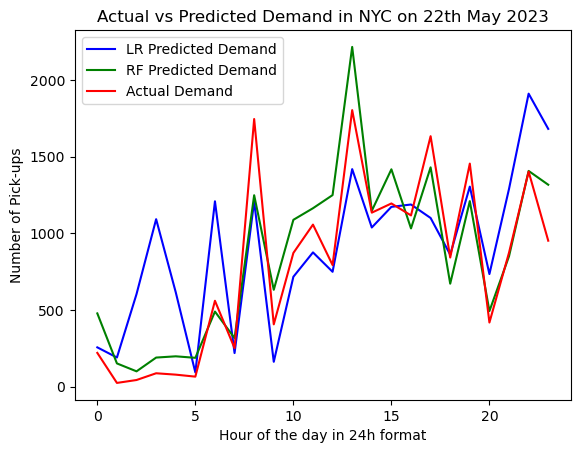

In [38]:
# Set hour column as the x-axis
x = sample_df['hour']

# Plot multiple lines based on two model prediction and actual value
plt.plot(x, sample_df['lr_pred'], label='LR Predicted Demand', color = 'blue')
plt.plot(x, sample_df['rf_pred'], label='RF Predicted Demand', color = 'green')
plt.plot(x, sample_df['ground_truth'], label='Actual Demand', color = 'red')

# Add labels and legend
plt.xlabel('Hour of the day in 24h format')
plt.ylabel('Number of Pick-ups')
plt.title('Actual vs Predicted Demand in NYC on 22th May 2023')
plt.legend()

# Show the plot
# plt.show()
plt.savefig('../plots/prediction.png', dpi=300, bbox_inches='tight')